### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.exporess as px
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


### 2. Read Data

In [2]:
file_path = "./data/healthcare-dataset-stroke-data.csv"
data = pd.read_csv(file_path)
print(f"shape: {data.shape}")

data.head()

shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.isnull().mean() * 100

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [4]:
data.duplicated().sum()

0

In [5]:
data.drop(['id', 'gender', 'Residence_type'], axis=1, inplace=True)
data.shape

(5110, 9)

In [6]:
numerical_features   = data.select_dtypes(exclude='O').columns
categorical_features = data.select_dtypes('O').columns

print(f"{len(numerical_features)}  --> {numerical_features}")
print(f"{len(categorical_features)} --> {categorical_features}")

6  --> Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')
3 --> Index(['ever_married', 'work_type', 'smoking_status'], dtype='object')


In [7]:
discrete_features   = [col for col in numerical_features if len(data[col].unique()) <= 25]
continous_features  = [col for col in numerical_features if len(data[col].unique()) > 25]
#encoded_categorical = [col for col in numerical_features if len(data[col].unique()) < 5]

print(f"discrete_features  : {len(discrete_features)} | {discrete_features}")
print(f"continous_features : {len(continous_features)} | {continous_features}")
#print(f"encoded_categorical: {len(encoded_categorical)} | {encoded_categorical}")

discrete_features  : 3 | ['hypertension', 'heart_disease', 'stroke']
continous_features : 3 | ['age', 'avg_glucose_level', 'bmi']


In [8]:
data['bmi'] = data['bmi'].fillna(data['bmi'].median())
data['bmi'].isna().mean()

0.0

In [9]:
#!pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data[continous_features]
X['intercept'] = 1

vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif[vif['variables'] != 'intercept']
vif

,variables,vif
0,age,1.162810
1,avg_glucose_level,1.070325
2,bmi,1.128268


* Outlier 

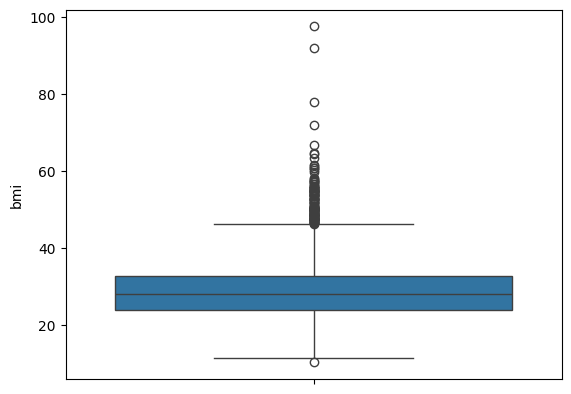

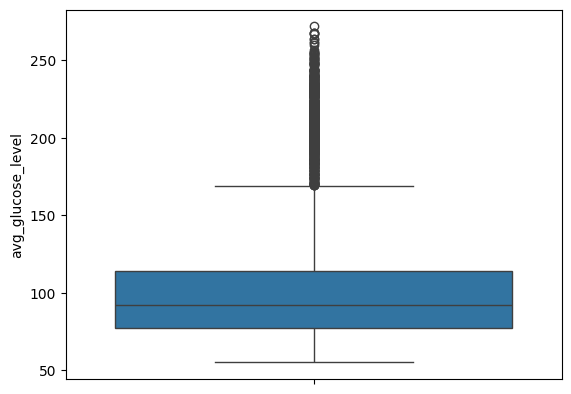

In [10]:
cols = ['bmi', 'avg_glucose_level']
for col in cols:
    sns.boxplot(data[col])
    plt.show()

In [11]:
def outlier_removal(df, column):
    upper_limit = df[column].mean() + 3*df[column].std()
    lower_limit = df[column].mean() - 3*df[column].std()
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

In [12]:
data.shape

(5110, 9)

(5051, 9)


<Axes: ylabel='bmi'>

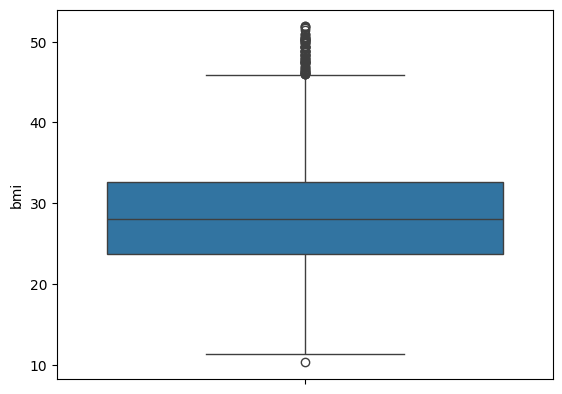

In [13]:
#sns.boxplot(data['bmi'])
data = outlier_removal(data, 'bmi')
print(data.shape)
sns.boxplot(data['bmi'])

<Axes: ylabel='bmi'>

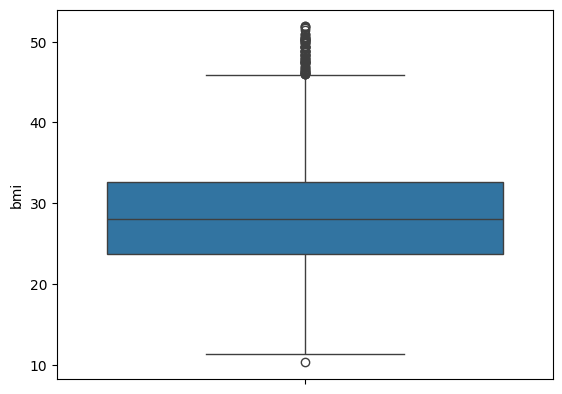

In [14]:
sns.boxplot(data['bmi'])

In [15]:
data[continous_features].skew()

age                 -0.134358
avg_glucose_level    1.583938
bmi                  0.479761
dtype: float64

### Train-Test split

In [16]:
X = data.drop('stroke', axis=1)
y = data['stroke']
print(X.shape, y.shape)

(5051, 8) (5051,)


In [17]:
for col in categorical_features:
    print(col, X[col].nunique())

ever_married 2
work_type 5
smoking_status 4


In [18]:
categorical_features = X.select_dtypes(include='O').columns.to_list()
num_features = numerical_features.copy().to_list()
num_features.remove('stroke') 
transform_features = ['avg_glucose_level']

print(categorical_features, num_features, transform_features)

['ever_married', 'work_type', 'smoking_status'] ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'] ['avg_glucose_level']


In [19]:
numeric_pipeline=Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler' , StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
    ('scaler' , StandardScaler(with_mean=False))
])

transform_pipeline = Pipeline(steps=[
    ('transformer', PowerTransformer(standardize=True))
])

preprocessor = ColumnTransformer(
    [
     ("numeric_pipeline", numeric_pipeline, num_features),   
     ("categoric_pipeline", categorical_pipeline, categorical_features),
     ("power_transform", transform_pipeline, transform_features)   
    ]
) 

In [20]:
X = preprocessor.fit_transform(X)
X

array([[ 1.04873045, -0.3247977 ,  4.167406  , ...,  0.        ,
         0.        ,  1.86920947],
       [ 0.78435386, -0.3247977 , -0.23995742, ...,  2.07166095,
         0.        ,  1.70694492],
       [ 1.62154639, -0.3247977 ,  4.167406  , ...,  2.07166095,
         0.        ,  0.39828325],
       ...,
       [-0.36127803, -0.3247977 , -0.23995742, ...,  2.07166095,
         0.        , -0.37985521],
       [ 0.34372621, -0.3247977 , -0.23995742, ...,  0.        ,
         0.        ,  1.40099247],
       [ 0.03528685, -0.3247977 , -0.23995742, ...,  0.        ,
         0.        , -0.28279525]])

In [21]:
smt = SMOTEENN(random_state=42, sampling_strategy="minority")
print(X.shape, y.shape)
x_res, y_res = smt.fit_resample(X, y)
print(x_res.shape, y_res.shape)

(5051, 17) (5051,)
(7942, 17) (7942,)


In [22]:
y.value_counts(), y_res.value_counts()

(stroke
 0    4803
 1     248
 Name: count, dtype: int64,
 stroke
 1    4167
 0    3775
 Name: count, dtype: int64)

In [23]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall    = recall_score(true, predicted)
    rocauc_score = roc_auc_score(true, predicted)
    return acc, f1, precision, recall, rocauc_score

In [24]:
models = {
    "Random Forest":RandomForestClassifier(),
    "Descision Tree" : DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression":LogisticRegression(),
    "k-nerighbors":KNeighborsClassifier(),
    "XGBClassifier":XGBClassifier(),
    "catboost":CatBoostClassifier(),
    "Adaboost":AdaBoostClassifier()
}

In [25]:
def evaluate_models(X, y, models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

    model_list = []
    accuracy_list = []
    auc = []

    for i in range(len(models)):
        model = list(models.values())[i]
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)

        train_acc, train_f1, train_precision, train_recall, train_roc_auc_score = evaluate_clf(y_train, y_train_pred)
        test_acc, test_f1, test_precision, test_recall, test_roc_auc_score = evaluate_clf(y_test, y_test_pred)

        model_list.append(list(models.keys())[i])
        print(list(models.keys())[i])
        print("Model performance on train set")
        print('train_acc', train_acc) 
        print('train_f1', train_f1) 
        print('train_precision', train_precision) 
        print('train_recall', train_recall)
        print('train_roc_auc_score', train_roc_auc_score)

        print("Model performance on test set")
        print('test_acc', test_acc) 
        print('test_f1', test_f1) 
        print('test_precision', test_precision) 
        print('test_recall', test_recall)
        print('test_roc_auc_score', test_roc_auc_score)
        print('='*40)

        accuracy_list.append(test_acc)
    
    print(model_list, accuracy_list)
    report = pd.DataFrame(list(zip(model_list, accuracy_list)), columns=['model', 'accuracy']).sort_values(by=['accuracy'], ascending=False)
    return report

In [26]:
report = evaluate_models(x_res, y_res, models)
report

(6353, 17) (6353,)
(1589, 17) (1589,)
Random Forest
Model performance on train set
train_acc 1.0
train_f1 1.0
train_precision 1.0
train_recall 1.0
train_roc_auc_score 1.0
Model performance on test set
test_acc 0.974826935179358
test_f1 0.9759036144578314
test_precision 0.9563164108618654
test_recall 0.996309963099631
test_roc_auc_score 0.9743147753642485
Descision Tree
Model performance on train set
train_acc 1.0
train_f1 1.0
train_precision 1.0
train_recall 1.0
train_roc_auc_score 1.0
Model performance on test set
test_acc 0.9395846444304594
test_f1 0.9424460431654677
test_precision 0.9192982456140351
test_recall 0.966789667896679
test_roc_auc_score 0.9389360710617415
Gradient Boosting
Model performance on train set
train_acc 0.9239729261766094
train_f1 0.9296226140171936
train_precision 0.9090909090909091
train_recall 0.951103160405486
train_roc_auc_score 0.9223671854044769
Model performance on test set
test_acc 0.9118942731277533
test_f1 0.9164677804295943
test_precision 0.889918887

,model,accuracy
0,Random Forest,0.974827
5,XGBClassifier,0.964758
4,k-nerighbors,0.963499
6,catboost,0.959723
1,Descision Tree,0.939585
2,Gradient Boosting,0.911894
7,Adaboost,0.876652
3,Logistic Regression,0.864695


In [32]:
xgboost_params = {'learning_rate':[0.1, 0.01], 'max_depth':[5,8,12,20,30], 'n_estimators':[100,200,300], 'colsample_bylevel':[0.1, 0.4, 0.5, 0.8,1]}
#cat_params = {'learning_rate':[0.1, 0.01], 'max_depth':[10,15,20,30]}
rf_params  = {'max_depth':[10,12,15,None], 'max_features':['sqrt', 'log2', None], 'min_samples_split':[100,150,200,250], 'n_estimators':[10,50,100,200]}
knn_params = {'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'weights':['uniform', 'distance'], 'n_neighbors':[3,4,5,7,9]}

In [33]:
 randomcv_models = [('RF', RandomForestClassifier(), rf_params),
                   ('XGboost', XGBClassifier(), xgboost_params),
                   #('catboost', CatBoostClassifier(), cat_params),
                   ('knn', KNeighborsClassifier(), knn_params)]

In [34]:
model_param = {}
for model_name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                param_distributions=params,
                                n_iter=100,
                                cv=3, 
                                verbose=2,
                                n_jobs=-1)
    random.fit(x_res, y_res)
    model_param[model_name] = random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [39]:
for model in model_param.keys():
    print('+++++')
    print(f"{model} - {model_param[model]}")


+++++
RF - {'n_estimators': 100, 'min_samples_split': 100, 'max_features': 'log2', 'max_depth': None}
+++++
XGboost - {'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bylevel': 0.4}
+++++
knn - {'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}


In [41]:
best_models = {
    "rf": RandomForestClassifier(**model_param["RF"]),
    "XGboost ": XGBClassifier(**model_param["XGboost"]),
    "knn ": KNeighborsClassifier(**model_param["knn"])
}

report = evaluate_models(x_res, y_res, best_models)
report

(6353, 17) (6353,)
(1589, 17) (1589,)
rf
Model performance on train set
train_acc 0.9220840547772706
train_f1 0.9278741075331488
train_precision 0.9073810202336848
train_recall 0.9493142516398331
train_roc_auc_score 0.920472397577169
Model performance on test set
test_acc 0.9093769666456891
test_f1 0.9140811455847255
test_precision 0.8876013904982619
test_recall 0.942189421894219
test_roc_auc_score 0.9085947109471094
XGboost 
Model performance on train set
train_acc 1.0
train_f1 1.0
train_precision 1.0
train_recall 1.0
train_roc_auc_score 1.0
Model performance on test set
test_acc 0.9741976085588421
test_f1 0.9753753753753753
test_precision 0.9530516431924883
test_recall 0.998769987699877
test_roc_auc_score 0.9736117979736498
knn 
Model performance on train set
train_acc 1.0
train_f1 1.0
train_precision 1.0
train_recall 1.0
train_roc_auc_score 1.0
Model performance on test set
test_acc 0.9830081812460667
test_f1 0.9836065573770492
test_precision 0.9712230215827338
test_recall 0.9963099

,model,accuracy
2,knn,0.983008
1,XGboost,0.974198
0,rf,0.909377


In [44]:
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, random_state=42, test_size=0.2)
best_model = KNeighborsClassifier(**model_param["knn"])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

score = accuracy_score(y_test, y_pred)
score

0.9830081812460667

In [47]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       776
           1       0.97      1.00      0.98       813

    accuracy                           0.98      1589
   macro avg       0.98      0.98      0.98      1589
weighted avg       0.98      0.98      0.98      1589



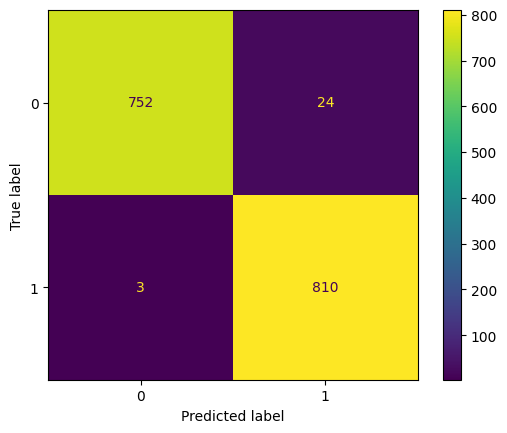

In [48]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [51]:
from sklearn.model_selection import cross_val_score
for name, model in best_models.items():
    scores = cross_val_score(model, x_res, y_res, cv=3)
    print(f'cv scores {name} - {scores}')
    print('mean:', scores.mean())

cv scores rf - [0.89652568 0.90404231 0.91839819]
mean: 0.9063220594786855
cv scores XGboost  - [0.9592145  0.97355497 0.97884397]
mean: 0.9705378145697631
cv scores knn  - [0.98187311 0.97846619 0.97733283]
mean: 0.9792240431794759
